In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [2]:
# general settings

# device
device = torch.device('cuda' if use_gpu else 'cpu')

# batchsize
batchsize = 64

# seed setting (warning : cuDNN's randomness is remaining)
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)
    
# directory settings
# Data directory (for IR-MNIST)
data_dir = '../../data/IR-MNIST/'
train_data_dir = data_dir + 'Train_Samples/'
test_data_dir = data_dir + 'Test_Samples/'

# directory to put generated images
output_dir = data_dir + 'output/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# directory to save state_dict and loss.npy
save_dir = data_dir + 'save/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [3]:
# make dataset class for image loading
class MyDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_dir = os.listdir(root_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, idx):
        img_name = self.root_dir + self.list_dir[idx]
        image = Image.open(img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [ ]:
# define transforms
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# make dataset
imgDataset = MyDataset(train_data_dir, transform = tf)

# split into training data and validation data
train_data, validation_data = train_test_split(imgDataset, test_size = 0.2, random_state = seed)

print('The number of training data:', len(train_data))
print('The number of validation data :', len(validation_data))

In [ ]:
# make DataLoader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = True)

In [ ]:
# visualization of an example of training data
# comment out when runnnig in no GUI machine
def show_image(tensor_image):
    np_image = tensor_image.numpy()
    np_image = np.transpose(np_image, [1, 2, 0]) * 0.5 + 0.5
    plt.imshow(np_image)
    
X = iter(train_loader).next()[0]
print(X.size())
show_image(X)

In [ ]:
# define downsampling parts for convenience
class Downsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Downsampler, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def only_Conv2d(self, x):
        return self.cv(x)
        
    def forward(self, x):
        out = self.cv(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [ ]:
# define upsampling parts for convenience
class Upsampler(nn.Module):
    def __init__(self, in_channels, out_channels, ksize = 4, ssize = 2, psize = 1):
        super(Upsampler, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = ksize, stride = ssize, padding = psize)
        self.bn = nn.BatchNorm2d(out_channels)
        self.rl = nn.ReLU()
        
    def only_ConvTranspose2d(self, x):
        return self.tc(x)
        
    def forward(self, x):
        out = self.tc(x)
        out = self.bn(out)
        out = self.rl(out)
        return out

In [27]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
                            Downsampler(  3,  8),
                            Downsampler(  8, 16),
                            Downsampler( 16, 32),
                            Downsampler( 32, 64)
         )
        
        self.decoder = nn.Sequential(
                            Upsampler( 64, 32),
                            Upsampler( 32, 16),
                            Upsampler( 16,  8),
                            nn.ConvTranspose2d( 8, 3, kernel_size = 4, stride = 2, padding = 1)
        )
        
    def get_feature_map(self, x, n_layers):
        if n_layers > len(self.encoder) or n_layers < 1:
            raise ValueError('n_layres must be in [1,2,...len(self_encoder)]')
            
        for i in range(n_layers-1):
            x = self.encoder[i](x)
        out = self.encoder[n_layers-1].only_conv(x)
        return out
        
    def forward(self, x):
        encode_x = self.encoder(x)
        recon_x = torch.tanh(self.decoder(encode_x))
        return recon_x

In [48]:
net = AutoEncoder().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0005, weight_decay = 0.0002)

loss_fn = nn.MSELoss()

num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

# モデルの構造、オプティマイザの表示
print('The number of trainable parameters:', num_trainable_params)
print('\nModel:\n', net)
print('\nLoss function:\n', loss_fn)
print('\nOptimizer:\n', optimizer)

The number of trainable parameters: 87315

Model:
 AutoEncoder(
  (encoder): Sequential(
    (0): Downsampler(
      (cv): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (1): Downsampler(
      (cv): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (2): Downsampler(
      (cv): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
    (3): Downsampler(
      (cv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rl): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Upsampler

In [49]:
# the function run training for 1 epoch
def train(train_loader):
    net.train()
    
    running_loss = 0
    
    for inputs in train_loader:
        inputs = inputs.to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    average_loss = running_loss / len(train_loader)
    
    return average_loss

In [50]:
# the function run validation
def validation(validation_loader):
    net.eval()
    
    running_loss = 0
    
    with torch.no_grad():
        for inputs in train_loader:
            inputs = inputs.to(device)
            outputs = net(inputs)
            running_loss += loss_fn(outputs, inputs).item()
    
    average_loss = running_loss / len(validation_loader)
    
    return average_loss

In [51]:
n_epochs = 50

train_loss_list = []
validation_loss_list = []

overfit = False
former_validation_loss = 1e10

for epoch in range(n_epochs):
    train_loss = train(train_loader)
    validation_loss = validation(validation_loader)
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' %(epoch+1, n_epochs, train_loss, validation_loss))
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    if former_validation_loss < validation_loss:
        if overfit:
            print('early stopping')
            break
        else:
            overfit = True
    else:
        overfit = False
    
    former_validation_loss = validation_loss
    
    # if epoch == 40:
    #    optimizer.param_groups[0]['lr'] /= 2
        
torch.save(net.state_dict(), save_dir + 'AE_IR_MNIST_start_8.pth')

epoch[1/50] train_loss:0.6646 validation_loss:1.7941
epoch[2/50] train_loss:0.3421 validation_loss:1.0352
epoch[3/50] train_loss:0.2183 validation_loss:0.7622
epoch[4/50] train_loss:0.1740 validation_loss:0.6455
epoch[5/50] train_loss:0.1523 validation_loss:0.5774
epoch[6/50] train_loss:0.1401 validation_loss:0.5402
epoch[7/50] train_loss:0.1326 validation_loss:0.5144
epoch[8/50] train_loss:0.1273 validation_loss:0.4962
epoch[9/50] train_loss:0.1227 validation_loss:0.4775
epoch[10/50] train_loss:0.1185 validation_loss:0.4606
epoch[11/50] train_loss:0.1147 validation_loss:0.4469
epoch[12/50] train_loss:0.1109 validation_loss:0.4297
epoch[13/50] train_loss:0.1068 validation_loss:0.4163
epoch[14/50] train_loss:0.1023 validation_loss:0.3967
epoch[15/50] train_loss:0.0979 validation_loss:0.3789
epoch[16/50] train_loss:0.0931 validation_loss:0.3597
epoch[17/50] train_loss:0.0881 validation_loss:0.3398
epoch[18/50] train_loss:0.0828 validation_loss:0.3160
epoch[19/50] train_loss:0.0775 valida

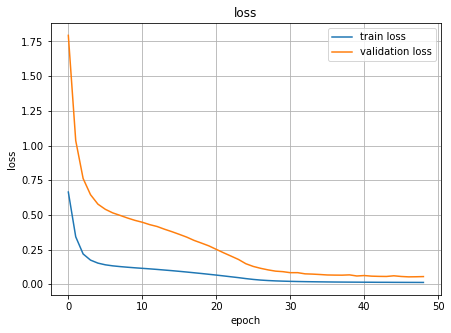

In [52]:
# visualize training log
plt.figure(figsize = (7,5))
plt.plot(train_loss_list, label = 'train loss')
plt.plot(validation_loss_list, label = 'validation loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [54]:
test_data = MyDataset(test_data_dir, transform = tf)
test_loader = DataLoader(test_data, batch_size = batchsize, shuffle = True)

In [58]:
normal_data = iter(validation_loader).next().to(device)
abnormal_data = iter(test_loader).next().to(device)

In [59]:
net.eval()
with torch.no_grad():
    normal_recon_data = net(normal_data)
    abnormal_recon_data = net(abnormal_data)

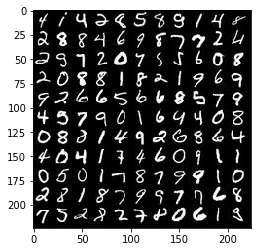

In [65]:
index = 0
show_image(normal_data[index].cpu())

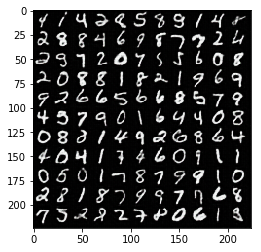

In [66]:
show_image(normal_recon_data[index].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


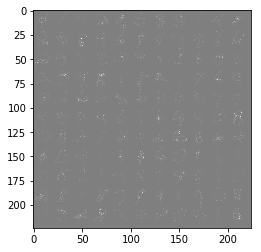

In [81]:
show_image((normal_recon_data[index] - normal_data[index]).pow(2).div(2).cpu())

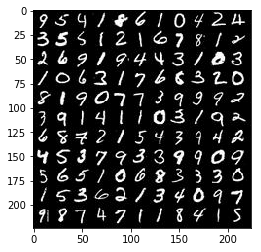

In [68]:
index2 = 0
show_image(abnormal_data[index2].cpu())

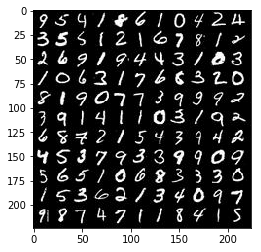

In [69]:
show_image(abnormal_data[index2].cpu())

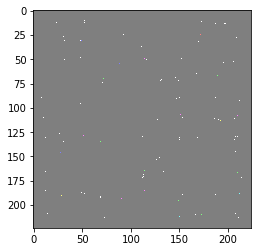

In [84]:
show_image((abnormal_recon_data[index] - abnormal_data[index]).pow(2).div(2).cpu() > 0.3)